<a href="https://colab.research.google.com/github/HamzaGbada/Numba-cuda/blob/main/Numba_CUDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

فَلَو أَنَّ ما أَسعى لِأَدنى مَعيشَةٍ **** كَفاني وَلَم أَطلُب قَليلٌ مِنَ المالِ

وَلَكِنَّما أَسعى لِمَجدٍ مُؤَثَّلٍ **** وَقَد يُدرِكُ المَجدَ المُؤَثَّلَ أَمثالي

امرؤ القيس

In this notebook, we will discuss how to do parallel computing on your GPU with CUDA using python!

The [NVIDIA® CUDA® Toolkit](https://developer.nvidia.com/cuda-toolkit) provides a development environment for creating high performance GPU-accelerated applications.

We will cover these sections:

1.   Cuda kernel
2.   Memory management
3.   Device function
4.   Threads and blocks configuration
5.   Application in image processing


Before we start, let us take a look on what is [Numba](https://numba.pydata.org/).

So Numba is a just-in-time compiler that translates python code into machine code using [LLVM](https://llvm.org/), which makes numerical alogrithms execution speed in Python comparable to C or FORTRAN algorithms.



# Cuda Kernel

At first we must check the [CUDA programming terminology](https://numba.pydata.org/numba-doc/dev/cuda/overview.html#terminology), let's take a minimal example where we add 2 for each element of a vector:

In [ ]:
from numba import cuda

@cuda.jit
def add_gpu(x, out):
  idx = cuda.grid(1)
  out[idx] = x[idx] + 2

Let's discuss this code in some detail:

When writing CUDA kernel, we must declare the input and the output of the kernel as an argument.
But, What is `cuda.grid(1)`?

`cuda.grid(1)` returns the unique index for the current thread in the whole grid. With N threads, idx will range from 0 to N. We will discuss thread indexing in more details in section 4.



Now, we setup our data

In [ ]:
import numpy as np

a = np.arange(10,dtype=np.float32)

# send input vector to the device
d_a = cuda.to_device(a)

# create output vector on the device
d_out = cuda.device_array_like(d_a)

In [ ]:
# we decide to use 2 blocks, each containing 5 threads for our vector
nbr_block_per_grid = 2
nbr_thread_per_block = 5
add_gpu[nbr_block_per_grid, nbr_thread_per_block](d_a, d_out)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


In [ ]:
# now we get our output
out = d_out.copy_to_host()
out

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.], dtype=float32)

Le Voilà!

Let's compare it to a CPU function

In [ ]:
def add_cpu(x):
   for i in range(x.size):
     x[i]+=2
   return x

In [ ]:
%timeit add_gpu[nbr_block_per_grid, nbr_thread_per_block](d_a, d_out)

47.5 µs ± 9.57 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
%timeit add_cpu(a)

22.6 µs ± 4.09 µs per loop (mean ± std. dev. of 7 runs, 100000 loops each)


 Wait! What is that! The CPU version is about 6 times faster!

Let's understand what is happening: when running on the GPU, the following steps are performed:

1. the input data (the array a) is transferred to the GPU memory;
the calculation of the square root is done in parallel on the GPU for all elements of a.
2. the resulting array is sent back to the host system.

If the calculation is too simple, the time spent in calculation is negligible compared to the data transfer time.


Let's see what happens with a more involved calculation.

In [ ]:
import numpy as np

a = np.arange(32768,dtype=np.float32)

# send input vector to the device
d_a = cuda.to_device(a)

# create output vector on the device
d_out = cuda.device_array_like(d_a)

# we decide to use 2 blocks, each containing 5 threads for our vector
nbr_block_per_grid = 32
nbr_thread_per_block = 1024
add_gpu[nbr_block_per_grid, nbr_thread_per_block](d_a, d_out)

%timeit add_gpu[nbr_block_per_grid, nbr_thread_per_block](d_a, d_out)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


43.2 µs ± 759 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [ ]:
%timeit add_cpu(a)

64.6 ms ± 665 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Now, it's clear! When we increase the size of our vector, the calculation became more complex and so the GPU version became faster!

**Conclusion:** When dealing with simple data and calculation, it's a waste of time to use GPU.


# Memory management

In the last section, we have seen a little example of memory management without any explanation. So the main idea of this section is to learn how to deal with data transfers between ***Host*** and ***Device***.

It is advisable to minimize data transfers to improve performance and this can be done with device arrays.

To show this in a simple way, we will use an example of normalizing pixel range of an image from [0,255] into [0,10], our calculations will be based on this formula:

$j =  10 \times \frac{i}{255} \;\;\; \forall 0 \leq i\leq 255 $

where $i$ is the intensity of the initiale image and $j$ is the output.

After that, we will perfom a Gamma Correction based on this function:

$f(V)=V^\alpha \: \: \: \; \alpha>0$


Before we start let's see how they operate in CPU

In [ ]:
import numpy as np

n = 512

# The image will be generated randomly as numpy array
image = np.random.randint(256, size=(n, n))

def normlize_image(image):
  return image*10 / 255

def gamma_correction(image, gamma):
  image = np.power(image / float(10), gamma)
  return image * 10

In [ ]:
%%timeit
gamma = 0.5

norm_img = normlize_image(image)

gamma_corr = gamma_correction(image, gamma)

6.65 ms ± 46.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Now, we will implement the cuda kernel of the functions above,

In [ ]:
from numba import cuda
from operator import pow
import numpy as np

@cuda.jit
def normalize_image_gpu(image, out):

  i, j = cuda.grid(2)
  out[i,j] = ((image[i,j])/(255)) * 10

@cuda.jit
def gamma_correction_gpu(image, out, gamma):
  i, j = cuda.grid(2)
  out[i,j] = pow(image[i,j], gamma)


So what we should do is:

1. transfer the image to the device
2. Create intermediate arrays on the device (an empty array with the same features as the image array)
3.  Create the output array on the device (for the gamma correction output) with the same shape as the input but with a different data type (numpy.float because the gamma coefficient is float)

In [ ]:
gamma = 0.5

blockdim = (32, 32)
griddim = (image.shape[0] // blockdim[0] + 1, image.shape[1] // blockdim[1] + 1)
# data transfer to device
d_image = cuda.to_device(image)
d_normlized = cuda.device_array_like(image)
d_gamma = cuda.device_array((image.shape[0], image.shape[1]), dtype=np.float_)

In [ ]:
%%timeit
normalize_image_gpu[griddim, blockdim](d_image, d_normlized)
gamma_correction_gpu[griddim, blockdim](d_normlized, d_gamma, gamma)

127 µs ± 56.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Finally, here is how to retrieve the gamma correction result:

In [ ]:
gamma_result = d_gamma.copy_to_host()
gamma_result

array([[2.64575131, 0.        , 2.44948974, ..., 1.73205081, 3.        ,
        1.        ],
       [2.23606798, 0.        , 1.41421356, ..., 2.44948974, 2.23606798,
        3.        ],
       [2.23606798, 1.        , 1.41421356, ..., 2.82842712, 1.41421356,
        0.        ],
       ...,
       [0.        , 1.41421356, 2.82842712, ..., 1.73205081, 1.        ,
        2.23606798],
       [0.        , 0.        , 2.82842712, ..., 2.44948974, 2.82842712,
        1.        ],
       [2.44948974, 2.82842712, 1.        , ..., 1.        , 2.44948974,
        2.23606798]])

# Device function

In the examples above we have seen how to write cuda kernel of simple functions, but what if we need to write a more complex function and we face a problem where we need to call another function, what we should do? We have two options:

1. Implement everything in the same kernel and this solution sounds bad, it made our code a Spaghetti code.
2. Create multiple cuda kernels and call them inside other kernels, this [feature](http://developer.download.nvidia.com/GTC/PDF/GTC2012/PresentationPDF/S0338-GTC2012-CUDA-Programming-Model.pdf) is called [*dynamic parallelism*](https://developer.nvidia.com/blog/cuda-dynamic-parallelism-api-principles/), but unfortunately Numba does not support it yet.

So, we need another solution: it's time for the **Device function** to shine!

CUDA device functions can only be invoked from within the device (by a kernel or another device function).
Unlike a kernel function, a device function can return a value like normal functions.


Let's write a device function that's similar to *numpy.max*.

Note: *numpy.max* is not supported by Numba, check [this](https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html) to see supported NumPy features.


In [ ]:
@cuda.jit(device=True)
def maximum_device(arr):
  max = arr[0,0]
  for i in range(arr.shape[0]):
    for j in range(arr.shape[1]):
      if arr[i,j]>=max:
        max = arr[i,j]
  return max

In [ ]:
import numpy as np

n = 512

image = np.random.randint(256, size=(n, n))

maximum_device(image)

ValueError: 
Kernel launch configuration was not specified. Use the syntax:

kernel_function[blockspergrid, threadsperblock](arg0, arg1, ..., argn)

See https://numba.readthedocs.io/en/stable/cuda/kernels.html#kernel-invocation for help.



Ah yes I forget! The Device function should only be declared inside CUDA kernel. We will modify our Gamma Correction Kernel!

In [ ]:
@cuda.jit
def gamma_correction_device(image, out, gamma):
  i, j = cuda.grid(2)
  maximum = maximum_device(image)
  out[i,j] = pow(image[i,j], gamma) / maximum

gamma = 0.5

blockdim = (32, 32)
griddim = (image.shape[0] // blockdim[0] + 1, image.shape[1] // blockdim[1] + 1)
# data transfer to device
d_image = cuda.to_device(image)
d_normlized = cuda.device_array_like(image)
d_gamma = cuda.device_array((image.shape[0], image.shape[1]), dtype=np.float_)

In [ ]:
%%timeit
normalize_image_gpu[griddim, blockdim](d_image, d_normlized)
gamma_correction_device[griddim, blockdim](d_normlized, d_gamma, gamma)

138 µs ± 66.7 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


As we can see the device function does not affect the execution time.

It allows us to avoid code duplication.

Obviously, it is a bit artifial to use a device function in such an easy case. But when implementing complex algorithms, these functions can prove very useful.

# Threads and blocks configuration

From the begining, we were using `cuda.grid`, but we didn't explain it in detail. So in this section, we are going to describe it with the other features of indexing in GPU kernels.



In CUDA kernel, we didn't see any loop but we still perform indexing, and here a question rises: how can we perform indexing without any loop and each element is executed independently? We should know that threads are organized in blocks; blocks are grouped into a grid, and threads are
executed in kernel as a grid of blocks of threads all computing the same function. The threads of a block can be indentified (indexed) using 1Dimension(x), 2Dimensions (x,y) or 3Dim indexes (x,y,z) but in any case $xyz \leq 1024$ for our example (other restrictions apply to x,y and z, see the guide and your device capability).

Obviously, if you need more than those 4*768 threads you need more than 4 blocks. Blocks may also be indexed 1D, 2D or 3D. There is a queue of blocks waiting to enter the GPU (because, in our example, the GPU has 4 multiprocessors and only 4 blocks are being executed simultaneously).

Here is an image to explain the indexing more.
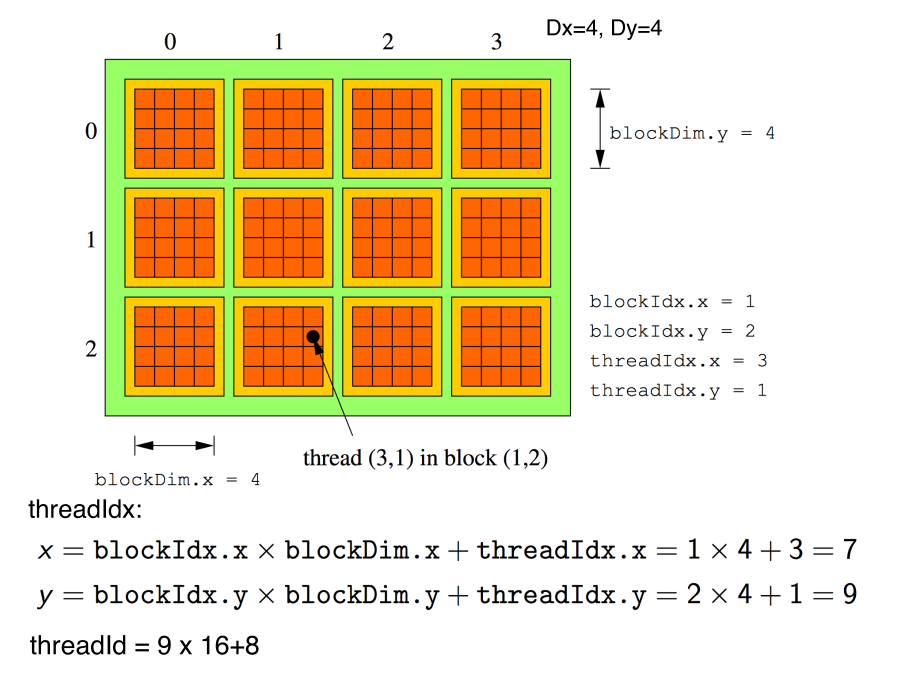

For simplicity, we can index using only one block and N threads by using `cuda.threadIdx.x`, but what we should know is that there are many restrictions.

1. The maximum number of threads in the block is limited to 1024. This is the product of whatever your threadblock dimensions are (xyz). For example (32,32,1) creates a block of 1024 threads. (33,32,1) is not legal, since $33\times32\times1 \gt 1024$.

2. The maximum x-dimension is 1024. (1024,1,1) is legal. (1025,1,1) is not legal.

3. The maximum y-dimension is 1024. (1,1024,1) is legal. (1,1025,1) is not legal.

4. The maximum z-dimension is 64. (1,1,64) is legal. (2,2,64) is also legal. (1,1,65) is not legal.

Also, threadblock dimensions of 0 in any position are not legal.

Your choice of threadblock dimensions (x,y,z) must satisfy each of the rules 1-4 above. For more check [Nvidia C/C++ basics guide](https://www.nvidia.com/docs/IO/116711/sc11-cuda-c-basics.pdf)

Let's go back to `cuda.grid(ndim)`, it return the absolute position of the current thread in the entire grid of blocks. ndim should correspond to the number of dimensions declared when instantiating the kernel. If ndim is 1, a single integer is returned. If ndim is 2 or 3, a tuple of the given number of integers is returned.

Computation of the first integer is as follows:

```
index = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
```
But, how does this formula work?
  * Consider indexing an array with one element per thread (5 threads per block)
  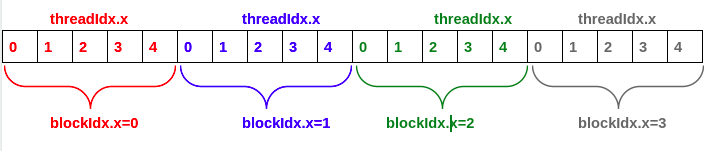

  * With M threads per block, a unique index for each thread is given by:
      ```
      index = cuda.threadIdx.x + blockIdx.x * M
      ```
  Here is an example:
    * which thread will operate on the yellow element?
  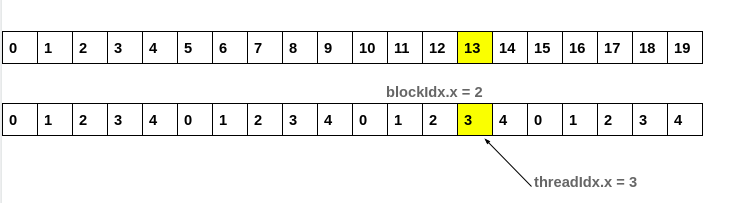

```
  index = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
        = 3 + 2 * 5
        = 13
```
But when dealing with Numba all of these indexings are simplified into
```
index = cuda.grid(1)
```




In [ ]:
from numba import cuda
import numpy as np

@cuda.jit
def convolve(result, mask, image):
    # expects a 2D grid and 2D blocks,
    # a mask with odd numbers of rows and columns, (-1-)
    # a grayscale image

    # (-2-) 2D coordinates of the current thread:
    i, j = cuda.grid(2)

    # (-3-) if the thread coordinates are outside of the image, we ignore the thread:
    image_rows, image_cols = image.shape
    if (i >= image_rows) or (j >= image_cols):
        return

    # To compute the result at coordinates (i, j), we need to use delta_rows rows of the image
    # before and after the i_th row,
    # as well as delta_cols columns of the image before and after the j_th column:
    delta_rows = mask.shape[0] // 2
    delta_cols = mask.shape[1] // 2

    # The result at coordinates (i, j) is equal to
    # sum_{k, l} mask[k, l] * image[i - k + delta_rows, j - l + delta_cols]
    # with k and l going through the whole mask array:
    s = 0
    for k in range(mask.shape[0]):
        for l in range(mask.shape[1]):
            i_k = i - k + delta_rows
            j_l = j - l + delta_cols
            # (-4-) Check if (i_k, j_k) coordinates are inside the image:
            if (i_k >= 0) and (i_k < image_rows) and (j_l >= 0) and (j_l < image_cols):
                s += mask[k, l] * image[i_k, j_l]
    result[i, j] = s

The code above is the implementation of the convolution matrix used in the image processing field: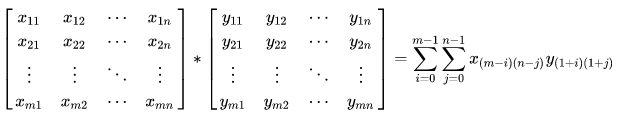

1. To simplify the kernel a bit, we will only use masks with odd numbers of rows and columns.

2. As we have seen, an easy way to get 2D coordinates is to use the convenience function cuda.grid(2).

3. We will divide the image in blocks of 32×32 pixels. Note that if we work on an image size that is not a multiple of 32, we have to be careful about the borders. That’s why we check if the thread coordinates are inside the image.

4. We check if $(i_k,j_k)$ coordinates are inside the image and when they are not, we just ignore the coordinates. This is equivalent to considering that the value of the image is 0 for coordinates outside of it.

Let's test our kernel!

In [ ]:
import numpy as np

n = 512

image = np.random.randint(256, size=(n, n))
d_image = cuda.to_device(image)

d_result = cuda.device_array_like(image)


# Create a random mask:
mask = np.random.rand(5, 5).astype(np.float32)
d_mask = cuda.to_device(mask)

blockdim = (32, 32)
griddim = (image.shape[0] // blockdim[0] + 1, image.shape[1] // blockdim[1] + 1)

# We apply our convolution to our image:
%timeit convolve[griddim, blockdim](d_result, d_mask, d_image)

149 µs ± 72.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
import scipy.ndimage
%timeit scipy.ndimage.correlate(image, mask, mode='constant')

9.92 ms ± 775 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Great results! We can see that our kernel is 70 time faster than the predefined function of `scipy.ndimage`

# Application in image processing

We reached the final section, we will now try to create kernel that defines the [Gaussian Blur](https://en.wikipedia.org/wiki/Gaussian_blur) of a grayscale image

In [ ]:
from math import exp
@cuda.jit
def gaussian_gpu(sigma, kernel_size, kernel):
  m = kernel_size // 2
  n = kernel_size // 2

  x = cuda.threadIdx.x
  y = cuda.threadIdx.y

  kernel[x,y] = exp(-((x-m) ** 2 + (y-n) ** 2) / (2 * sigma ** 2))

In [ ]:
sigma = 0.3
kernel_size = 3


kernel = np.zeros((kernel_size, kernel_size), np.float32)
d_kernel = cuda.to_device(kernel)

In [ ]:
%timeit gaussian_gpu[(1,), (kernel_size, kernel_size)](sigma, kernel_size, d_kernel)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


The slowest run took 4.87 times longer than the fastest. This could mean that an intermediate result is being cached.
73.1 µs ± 54.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Let's see our kernel in a real application!

In [ ]:
from PIL import Image, ImageOps
import numpy as np

image = np.asarray(ImageOps.grayscale(Image.open('gray.jpg')))
d_image = cuda.to_device(image)

d_result = cuda.device_array_like(image)

gaussian_gpu[(1,), (kernel_size, kernel_size)](sigma, kernel_size, d_kernel)

blockdim = (32, 32)
griddim = (image.shape[0] // blockdim[0] + 1, image.shape[1] // blockdim[1] + 1)

# We apply our convolution to our image:
convolve[griddim, blockdim](d_result, d_kernel, d_image)

FileNotFoundError: [Errno 2] No such file or directory: '/content/gray.jpg'

In [ ]:
result = d_result.copy_to_host()

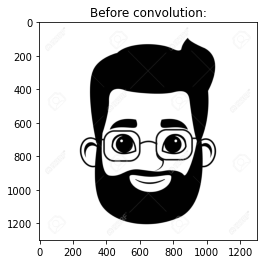

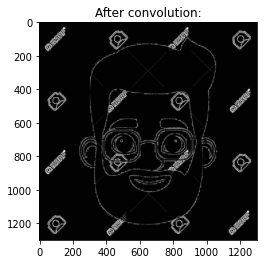

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(image, cmap='gray')
plt.title("Before convolution:")
plt.figure()
plt.imshow(result, cmap='gray')
plt.title("After convolution:")
plt.show()